# Quantization and Inference Demo

This notebook demonstrates the quantization process and inference capabilities of our ResNet-18 model. We'll:
1. Load and quantize the trained model
2. Compare performance metrics
3. Visualize quantization effects
4. Run comprehensive benchmarks

## Setup and Imports
First, let's import all necessary libraries and set up our environment.

In [14]:
import os
import sys
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from typing import Dict, Tuple, List
from torch import nn

# Add project root to path
sys.path.append('..')
from src.models import create_resnet18
from src.utils.data import get_cifar10_data
from src.utils.benchmarking import evaluate_model_performance, print_benchmark_results
from src.utils.visualization import plot_confusion_matrix, plot_misclassified_examples

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Use CPU for consistent benchmarking
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


## Utility Functions
Define helper functions for model loading, memory profiling, and quantization.

In [15]:
def safe_load_model(model_path: str, device: torch.device) -> torch.nn.Module:
    try:
        model = create_resnet18()
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        raise

def profile_model_memory(model: torch.nn.Module) -> Dict:
    memory_stats = {}
    total_params = 0
    total_size = 0
    
    for name, param in model.named_parameters():
        if param is not None:  # Check if parameter exists
            param_size = param.numel() * param.element_size()
            memory_stats[name] = {
                'shape': list(param.shape),
                'size_bytes': param_size,
                'size_mb': param_size / (1024 * 1024)
            }
            total_params += param.numel()
            total_size += param_size
    
    return {
        'total_params': total_params,
        'total_size_mb': total_size / (1024 * 1024),
        'detailed_stats': memory_stats
    }

def quantize_model(model: torch.nn.Module, 
                  calibration_loader: torch.utils.data.DataLoader,
                  num_calibration_batches: int = 10) -> torch.nn.Module:
    try:
        # Create a copy of the model for quantization
        quantized_model = create_resnet18()
        quantized_model.load_state_dict(model.state_dict())
        quantized_model.to('cpu')  # Quantization must be done on CPU
        quantized_model.eval()
        
        # Fuse layers
        print("Fusing layers...")
        quantized_model.fuse_model()
        
        # Configure quantization
        print("Configuring quantization...")
        quantized_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.quantization.prepare(quantized_model, inplace=True)
        
        # Calibrate
        print("Calibrating...")
        with torch.no_grad():
            for i, (data, _) in enumerate(tqdm(calibration_loader, desc="Calibration")):
                data = data.to('cpu')
                quantized_model(data)
                if i >= num_calibration_batches:
                    break
        
        # Convert to quantized model
        print("Converting to quantized model...")
        torch.quantization.convert(quantized_model, inplace=True)
        return quantized_model
    
    except Exception as e:
        print(f"Error during quantization: {str(e)}")
        raise

## Benchmarking Functions
Define functions for performance benchmarking and analysis.

In [16]:
def benchmark_inference(model: torch.nn.Module, 
                       dataset,
                       batch_sizes: List[int] = [1, 4, 8, 16, 32, 64, 128]) -> Dict:
    results = {}
    
    for batch_size in batch_sizes:
        print(f"\nBenchmarking batch size: {batch_size}")
        loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )
        
        # Warmup
        with torch.no_grad():
            for i, (images, _) in enumerate(loader):
                if i >= 5:  # 5 warmup batches
                    break
                _ = model(images)
        
        # Measure inference time
        times = []
        with torch.no_grad():
            for images, _ in tqdm(loader, desc="Measuring"):
                start = time.perf_counter()
                _ = model(images)
                end = time.perf_counter()
                times.append((end - start) * 1000)  # ms
        
        results[batch_size] = {
            'avg_batch_time': np.mean(times),
            'std_batch_time': np.std(times),
            'avg_sample_time': np.mean(times) / batch_size
        }
    
    return results

## Visualization Functions
Define functions for visualizing quantization effects and model analysis.

In [17]:
def visualize_quantization_results(orig_model, quant_model, test_loader, classes):
    """Visualize quantization effects with confusion matrices and misclassified examples."""
    # Get predictions
    def get_predictions(model):
        all_preds = []
        all_targets = []
        model.eval()
        with torch.no_grad():
            for images, targets in tqdm(test_loader, desc="Getting predictions"):
                outputs = model(images)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.numpy())
        return np.array(all_preds), np.array(all_targets)
    
    # Get predictions for both models
    orig_preds, targets = get_predictions(orig_model)
    quant_preds, _ = get_predictions(quant_model)
    
    # Plot confusion matrices
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(targets, orig_preds, classes, "Original Model Confusion Matrix")
    
    plt.subplot(1, 2, 2)
    plot_confusion_matrix(targets, quant_preds, classes, "Quantized Model Confusion Matrix")
    
    plt.tight_layout()
    plt.show()
    
    # Plot misclassified examples
    plot_misclassified_examples(test_loader.dataset, quant_preds, targets, classes)

def analyze_layer_compression(orig_model, quant_model):
    """Analyze compression ratio for each layer."""
    orig_sizes = {}
    quant_sizes = {}
    
    # Get layer sizes for both models
    for name, module in orig_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            orig_sizes[name] = sum(p.numel() * p.element_size() for p in module.parameters())
    
    for name, module in quant_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            quant_sizes[name] = sum(p.numel() * p.element_size() for p in module.parameters())
    
    # Plot results
    plt.figure(figsize=(12, 6))
    layers = list(orig_sizes.keys())
    x = np.arange(len(layers))
    width = 0.35
    
    plt.bar(x - width/2, [orig_sizes[l]/1024 for l in layers], width, label='Original')
    plt.bar(x + width/2, [quant_sizes[l]/1024 for l in layers], width, label='Quantized')
    
    plt.xlabel('Layers')
    plt.ylabel('Size (KB)')
    plt.title('Layer-wise Model Size Comparison')
    plt.xticks(x, layers, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print compression ratios
    print("\nLayer-wise Compression Analysis:")
    print(f"{'Layer':<20} {'Original (KB)':<15} {'Quantized (KB)':<15} {'Reduction %':<10}")
    print("-" * 60)
    for layer in layers:
        orig_kb = orig_sizes[layer]/1024
        quant_kb = quant_sizes[layer]/1024
        reduction = (1 - quant_kb/orig_kb) * 100
        print(f"{layer:<20} {orig_kb:<15.2f} {quant_kb:<15.2f} {reduction:<10.1f}")

## Main Execution
Load models, perform quantization, and run analysis.

Loading original model...
Original model loaded: 42.63 MB

Quantizing model...
Fusing layers...
Configuring quantization...
Calibrating...


/home/syphinx/documentation/DLCV/FP/venv/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Calibration:   0%|          | 0/391 [00:00<?, ?it/s]

Converting to quantized model...

Quantized model size: 0.01 MB
Size reduction: 99.98%

Running benchmarks...

Benchmarking batch size: 1


Measuring:   0%|          | 0/10000 [00:00<?, ?it/s]


Benchmarking batch size: 4


Measuring:   0%|          | 0/2500 [00:00<?, ?it/s]


Benchmarking batch size: 8


Measuring:   0%|          | 0/1250 [00:00<?, ?it/s]


Benchmarking batch size: 16


Measuring:   0%|          | 0/625 [00:00<?, ?it/s]


Benchmarking batch size: 32


Measuring:   0%|          | 0/313 [00:00<?, ?it/s]


Benchmarking batch size: 64


Measuring:   0%|          | 0/157 [00:00<?, ?it/s]


Benchmarking batch size: 128


Measuring:   0%|          | 0/79 [00:00<?, ?it/s]


Benchmarking batch size: 1


Measuring:   0%|          | 0/10000 [00:00<?, ?it/s]


Benchmarking batch size: 4


Measuring:   0%|          | 0/2500 [00:00<?, ?it/s]


Benchmarking batch size: 8


Measuring:   0%|          | 0/1250 [00:00<?, ?it/s]


Benchmarking batch size: 16


Measuring:   0%|          | 0/625 [00:00<?, ?it/s]


Benchmarking batch size: 32


Measuring:   0%|          | 0/313 [00:00<?, ?it/s]


Benchmarking batch size: 64


Measuring:   0%|          | 0/157 [00:00<?, ?it/s]


Benchmarking batch size: 128


Measuring:   0%|          | 0/79 [00:00<?, ?it/s]

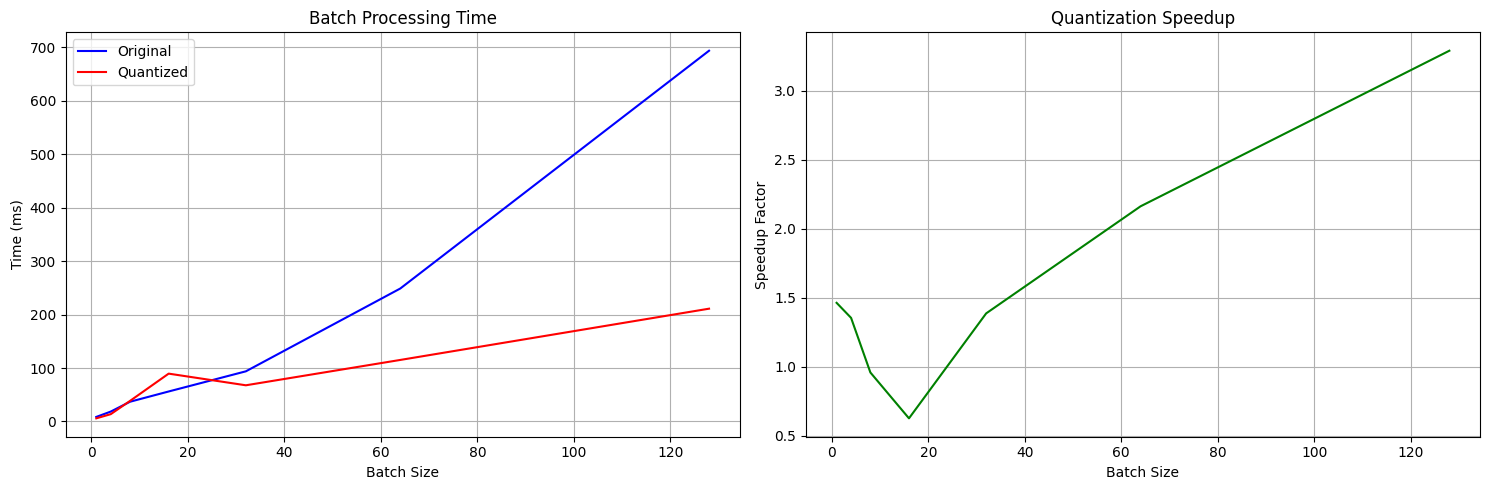


Generating visualization results...


Getting predictions:   0%|          | 0/79 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/79 [00:00<?, ?it/s]

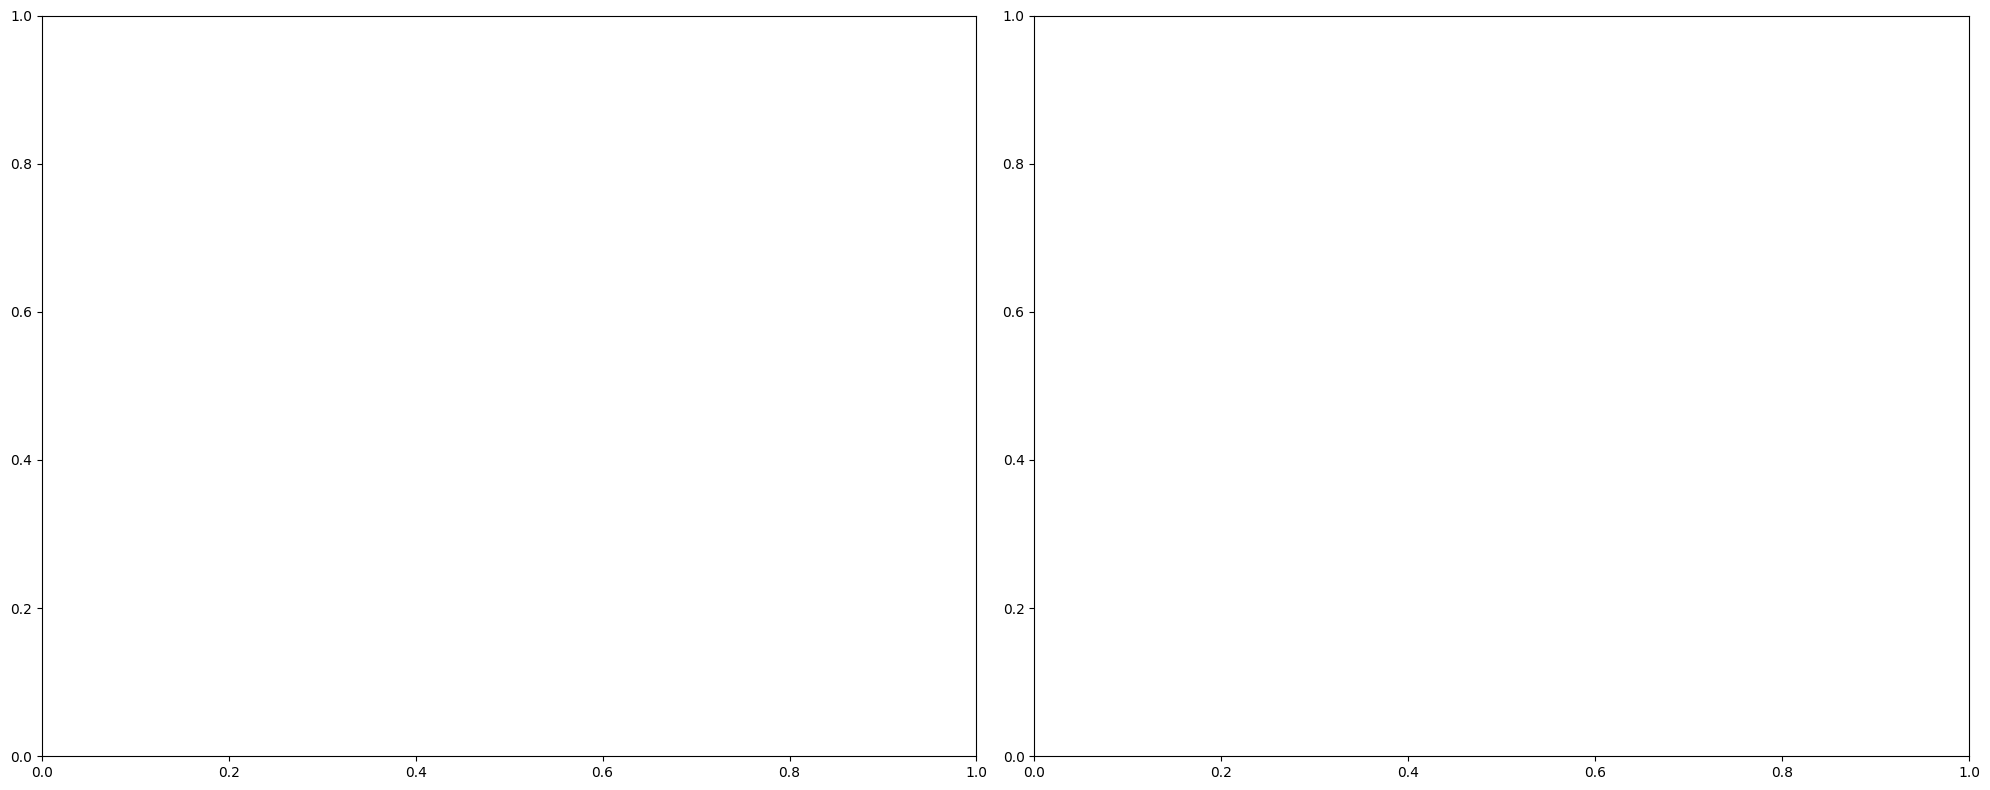


Analyzing layer-wise compression...
Error: 'conv1'


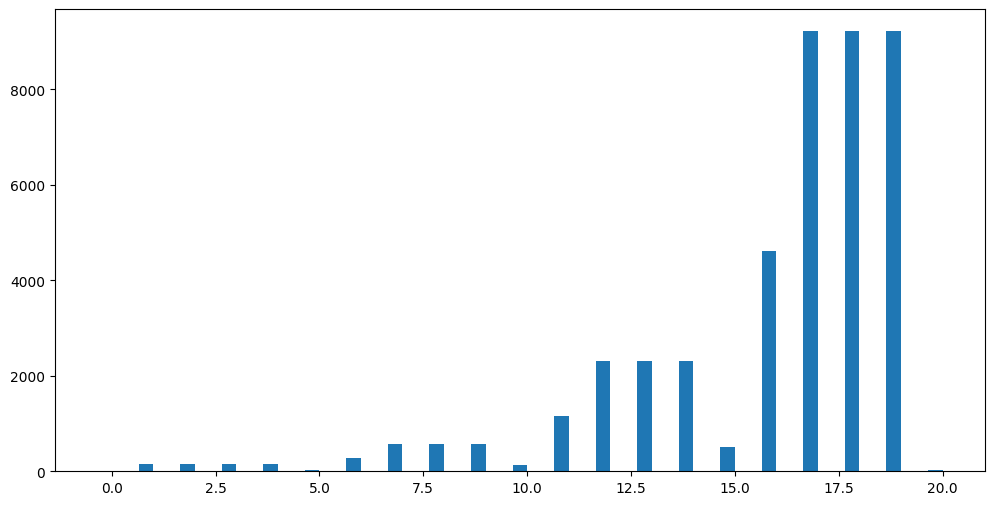

In [18]:
try:
    # Load original model
    print("Loading original model...")
    orig_model = safe_load_model('../models/resnet18_cifar10.pth', device)
    orig_memory = profile_model_memory(orig_model)
    print(f"Original model loaded: {orig_memory['total_size_mb']:.2f} MB")
    
    # Create data loaders
    test_loader = get_cifar10_data(batch_size=128, train=False)
    calibration_loader = get_cifar10_data(batch_size=128, train=True)
    classes = test_loader.dataset.classes
    
    # Quantize model
    print("\nQuantizing model...")
    quant_model = quantize_model(orig_model, calibration_loader)
    
    # Save quantized model
    os.makedirs('../models', exist_ok=True)
    torch.save(quant_model.state_dict(), '../models/quantized_resnet18_cifar10.pth')
    
    # Profile quantized model
    quant_memory = profile_model_memory(quant_model)
    print(f"\nQuantized model size: {quant_memory['total_size_mb']:.2f} MB")
    print(f"Size reduction: {(1 - quant_memory['total_size_mb']/orig_memory['total_size_mb'])*100:.2f}%")
    
    # Run benchmarks
    print("\nRunning benchmarks...")
    orig_benchmarks = benchmark_inference(orig_model, test_loader.dataset)
    quant_benchmarks = benchmark_inference(quant_model, test_loader.dataset)
    
    # Plot benchmark results
    plt.figure(figsize=(15, 5))
    
    # Plot batch times
    plt.subplot(1, 2, 1)
    batch_sizes = list(orig_benchmarks.keys())
    orig_times = [b['avg_batch_time'] for b in orig_benchmarks.values()]
    quant_times = [b['avg_batch_time'] for b in quant_benchmarks.values()]
    
    plt.plot(batch_sizes, orig_times, 'b-', label='Original')
    plt.plot(batch_sizes, quant_times, 'r-', label='Quantized')
    plt.title('Batch Processing Time')
    plt.xlabel('Batch Size')
    plt.ylabel('Time (ms)')
    plt.legend()
    plt.grid(True)
    
    # Plot speedup
    plt.subplot(1, 2, 2)
    speedups = [o/q for o, q in zip(orig_times, quant_times)]
    plt.plot(batch_sizes, speedups, 'g-')
    plt.title('Quantization Speedup')
    plt.xlabel('Batch Size')
    plt.ylabel('Speedup Factor')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Generate additional visualizations
    print("\nGenerating visualization results...")
    visualize_quantization_results(orig_model, quant_model, test_loader, classes)
    
    print("\nAnalyzing layer-wise compression...")
    analyze_layer_compression(orig_model, quant_model)
    
    # Save results
    os.makedirs('../results', exist_ok=True)
    results = {
        'original': {
            'memory': orig_memory,
            'benchmarks': orig_benchmarks
        },
        'quantized': {
            'memory': quant_memory,
            'benchmarks': quant_benchmarks
        }
    }
    torch.save(results, '../results/quantization_benchmarks.pt')
    print("\nResults saved successfully!")

except Exception as e:
    print(f"Error: {str(e)}")

## Conclusion

This notebook has:
1. Loaded and quantized the ResNet-18 model
2. Analyzed model size reduction and memory usage
3. Benchmarked inference performance
4. Visualized quantization effects through confusion matrices
5. Analyzed layer-wise compression ratios
6. Saved comprehensive results for further analysis

The quantized model is saved at '../models/quantized_resnet18_cifar10.pth' and 
detailed benchmarking results are saved at '../results/quantization_benchmarks.pt'.